In [1]:
# ! sudo apt-get install texlive-latex-recommended 
# ! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
# ! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
# ! unzipa type1cm.zip -d /tmp/type1cm 
# ! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
# ! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
# ! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
# ! sudo texhash 
# !apt install cm-super
# !pip3 install latex

In [2]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('text', usetex=True) # para usar latex en matplotlib

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra y Vicente Salinas

# Laboratorio 1

El objetivo de esta sesión práctica es aprender a resolver EDP’s en 2
dimensiones mediante el Método de las Diferencias Finitas.

Específicamente se resolverá la ecuación de Poisson en un rectángulo unitario y en un dominio perforado, además se estudiará la aproximación para condiciones de borde en dominios con curvatura

# Parte a


## Ecuación de Poisson

Considere la ecuación dada por

$$
\begin{equation}
\left.
\begin{array}[c]{rll}
-\Delta u= & 0 & \text{sobre }\Omega=\left[  0,1\right]^{2}\\
u(0,y)=u(1,y)= & 0 & \text{en }0\leq y\leq 1\\
u(x,0)= & 0 & \text{en }0\leq x\leq 1\\
u(x,1)= & g(x) & \text{en }0\leq x\leq 1
\end{array}
\right\} \quad (1)
\end{equation}
$$

Sea $N\in\mathbb{N}$, considere la aproximación del cuadrado unitario dado por la malla de puntos
$$
\Omega_{h}=\left\{  \left(  x_{j},y_{k}\right)  \mid j,k\in\left\{
0,1,\ldots,N+1\right\}  \right\}
$$
donde $x_{j}=jh$, $y_{k}=kh$, $h=\dfrac{1}{N+1}$. Se define el operador laplaciano discretizado por 5 puntos como
$$\Delta_{N}u_{j,k}=\dfrac{1}{h^{2}}\left(  u_{j+1,k}+u_{j-1,k}+  u_{j,k-1}+u_{j,k+1}-4u_{jk}\right)$$
donde $u_{jk}$ aproxima a $u\left(x_{j},y_{k}\right)  $.

Tomando $g(x) = \sin(\pi x)$, se puede demostrar que la solución única de esta ecuación está dada por

$$u\left(  x,y\right)  =\frac{\sin\left( \pi x\right)   \sinh\left( \pi y\right)  }{\sinh\left(  \pi\right) } $$

**P1.** Escriba dos funciones que calculen $\boldsymbol{A}_{h}$ y $\boldsymbol{b}_{h}$ de la forma más simple posible. Las entradas para estas funciones deben ser $N$ y $g$.

También escriba una función `solve` que, utilizando estas funciones (y las funciones auxiliares que necesite), entregue la solución aproximada.

**Indicación.** Revise la documentación del comando `kron` (disponible a través de `scypy.sparse`)

In [3]:
def Ah(N):
    h = 1/(N+1)

    "Creamos la matriz L4"
    e = np.ones(N)
    f = np.ones(N-1)
    k = np.array([-f,4*e,-f], dtype= object)
    offset = [-1,0,1]
    L4 = diags(k,offset)

    "Creamos una matriz por bloques con L4 en la diagonal"
    I = identity(N)
    AL4 = kron(I, L4)

    "Creamos una matriz por bloques con -I en la sub y sobrediagonal"
    d0d = np.array([-f,0,-f], dtype= object)
    offset = [-1,0,1]
    D0D = diags(d0d,offset)
    A1 = kron(D0D, I)

    "Obtenemos la matriz A sumando las matrices por bloques generadas"
    A = A1+AL4
    return A/(h**2)


def bh(N,f,g):
    h = 1/(N+1)

    "Inicializamos b como f"
    b = f

    "Para los puntos interiores con k=N le agregamos la condición de borde"
    for i in range(1, N+1):
        xi = i*h
        b[N*(N-1)+i-1] += g(xi)/(h**2)
    return b 

def solve(N, f, g):
    """Resuelve el problema del laplaciano en 2D en (0,1)^2, con condiciones
    Dirichlet en el borde, usando una grilla uniforme, con tamaño de
    paso h=1/(N+1) en x e y.
    """
    A = Ah(N)
    b = bh(N, f, g)
    u = spsolve(A, b)
    return u

**P2.** Resuelva la ecuación para $N = 10, 20, 30, 40, 50$. Comente sus resultados.

In [4]:
params = {"N": [10, 20, 30, 40, 50]}
g = lambda x: np.sin(np.pi*x)


"Resolvemos para cada N dado"
u = []
for N in params["N"]:
    uN = solve(N, np.zeros(N**2), g)
    u.append(uN)
    

"Añadimos el borde para cada N dado"
bu = []
for k, N in enumerate(params["N"]):
    buN = np.zeros((N+2, N+2))
    for i in range(N+2):
        for j in range(N+2):

            "Puntos interiores"
            if 0<i<N+1:
                if 0<j<N+1:
                    buN[i, j] += u[k].reshape(N, N)[i-1, j-1]

            "Agregamos condición de borde en la tapa superior"
            if i == N+1:
                h = 1/(N+1)
                buN[i, j] += g(j*h)
    bu.append(buN)
    
"Calculamos la solucion original para cada N dado"
u_org = []
fun_u_org = lambda x, y: np.sin(np.pi*x)*np.sinh(np.pi*y)/np.sinh(np.pi)
for N in params["N"]:
    xx = np.linspace(0,1,N+2)
    yy = np.linspace(0,1,N+2)
    X, Y = np.meshgrid(xx, yy, indexing="ij")
    Z = fun_u_org(Y, X)
    u_org.append(Z)

"Calculamos el error en norma 2"
error = []
for k, N in enumerate(params["N"]):
    buN = bu[k]
    Z = u_org[k]
    
    e = np.sum( (buN - Z) ** 2 ) ** 0.5
    
    error.append(e)

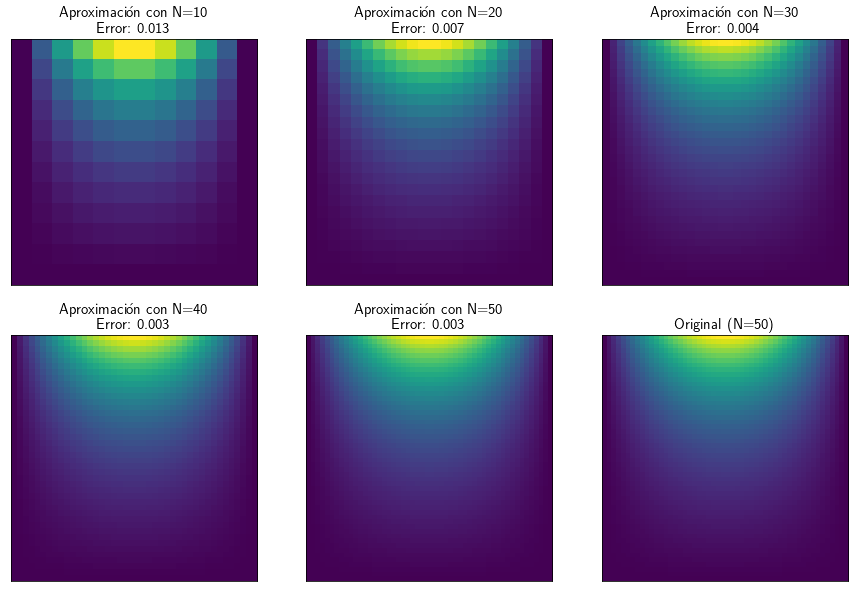

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(3*5, 2*5))
for k, N in enumerate(params["N"]):
    i, j = k//3, k%3
    axk = ax[i, j]
    buN = bu[k]
    
    axk.imshow(buN, origin="lower")
    axk.set_title(f"Aproximación con N={N} \n Error: {error[k]:.3f}", size=15)
    axk.set_xticks([])
    axk.set_yticks([])

axk = ax[1, 2]
axk.imshow(u_org[-1], origin="lower")
axk.set_title("Original (N=50)", size=15)
axk.set_xticks([])
axk.set_yticks([]);

**Comentarios:** En la figura anterior, para cada aproximacion con N puntos se dibuja la solucion obtenida y el error en norma 2 con la solucion real. Se observa que a medida de que N crece tanto el dibujo como el error mejoran. El primero, la imagen se vuelve mas suave cuando N crece. El segundo, el error disminuye cuando N crece.

**P3.** Estudie el condicionamiento en norma $2$ de la Matriz $A_h$.

**Indicación.** Sean $p\in\left[  1,+\infty\right]  $ y $\boldsymbol{A}\in\mathbb{R}^{N\times N}$. Se define la norma inducida $p$ de $\boldsymbol{A}$ como
$$
\left\Vert \boldsymbol{A}\right\Vert _{p}=\sup\limits_{\boldsymbol{x\in}\mathbb{R}^{N}\setminus\left\{  \boldsymbol{0}\right\}  }\dfrac{\left\Vert\boldsymbol{Ax}\right\Vert _{p}}{\left\Vert \boldsymbol{x}\right\Vert_{p}}
$$
y, si $\boldsymbol{A}$ es invertible, el número de condición en norma inducida $p$ como $\operatorname{cond}_{p}\left(  \boldsymbol{A}\right)  =\left\Vert
\boldsymbol{A}\right\Vert _{p}\left\Vert \boldsymbol{A}^{-1}\right\Vert _{p}$.

En este caso particular, como $\boldsymbol{A}_{h}$ es simétrica, el número de condición en la norma $2$ inducida puede calcularse como
$$
\operatorname{cond}_{2}\left(  \boldsymbol{A}_{h}\right)  =\dfrac{\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right)  }{\lambda_{\min,h}\left(\boldsymbol{A}_{h}\right)}
$$
donde $\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right)  =\max\left\{\left\vert \lambda\right\vert \mid\lambda\in\sigma\left(  \boldsymbol{A}_{h}\right)  \right\}  $ y $\lambda_{\min,h}\left(  \boldsymbol{A}_{h}\right)
=\min\left\{  \left\vert \lambda\right\vert \mid\lambda\in\sigma\left(\boldsymbol{A}_{h}\right)  \right\}  $.

In [6]:
def cond_2_sparse(A):
    """
    Calcula el numero de condicionamiento en norma inducida 2
    para una matriz sparse simetrica A.
    Se obtiene como el valor propio de mayor módulo dividido por el de menor módulo
    
    Input:
    - A matriz sparse simetrica
    
    Documentacion de eigsh:
    https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.sparse.linalg.eigsh.html
    """

    l_max = eigsh(A,k=1,which='LM')[0][0]
    l_min = eigsh(A,k=1,which='SM')[0][0]
    cond = l_max/l_min
    return cond

In [7]:
import time
import datetime

In [8]:
params = {"N": [4*(k+1) for k in range(50)]}

cond = []
times = []
for k, N in enumerate(params['N']):
    start_time = time.time()
    
    cond.append(cond_2_sparse(Ah(N)))
    
    dt = time.time()-start_time
    times.append(dt)
    print(f"""
    row: {k+1}, total_rows: {len(params['N'])}
    progress: {np.round(100*(k+1)/len(params['N']), 3)}%
    dt: {dt}
    expected end-time: {datetime.timedelta(seconds = np.mean(times)*(len(params['N'])-k-1))}s
    """)


    row: 1, total_rows: 50
    progress: 2.0%
    dt: 0.02302098274230957
    expected end-time: 0:00:01.128028s
    

    row: 2, total_rows: 50
    progress: 4.0%
    dt: 0.0040035247802734375
    expected end-time: 0:00:00.648588s
    

    row: 3, total_rows: 50
    progress: 6.0%
    dt: 0.004004240036010742
    expected end-time: 0:00:00.486117s
    

    row: 4, total_rows: 50
    progress: 8.0%
    dt: 0.006005048751831055
    expected end-time: 0:00:00.425889s
    

    row: 5, total_rows: 50
    progress: 10.0%
    dt: 0.008006572723388672
    expected end-time: 0:00:00.405363s
    

    row: 6, total_rows: 50
    progress: 12.0%
    dt: 0.010009765625
    expected end-time: 0:00:00.403701s
    

    row: 7, total_rows: 50
    progress: 14.0%
    dt: 0.012010335922241211
    expected end-time: 0:00:00.411943s
    

    row: 8, total_rows: 50
    progress: 16.0%
    dt: 0.017015457153320312
    expected end-time: 0:00:00.441399s
    

    row: 9, total_rows: 50
    progress: 

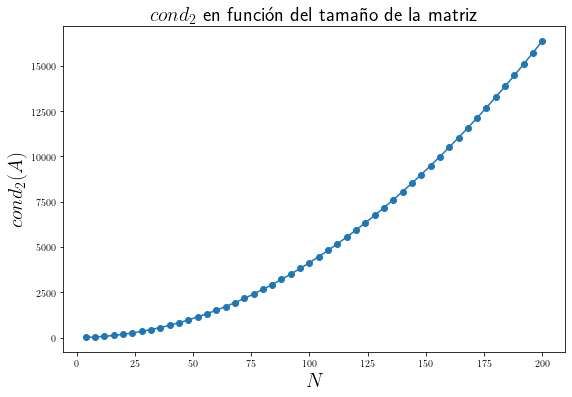

In [9]:
fig = plt.figure(figsize=(3*3, 2*3))
plt.scatter(params['N'],cond)
plt.plot(params['N'],cond)
plt.xlabel('$N$', size=20)
plt.ylabel('$cond_2(A)$', size=20)
plt.title('$cond_2$ en función del tamaño de la matriz', size=20)
plt.show()

**Comentarios:** If a matrix is singular, then its condition number is infinite. A finite large condition
number means that the matrix is close to being singular https://www.phys.uconn.edu/~rozman/Courses/m3511_18s/downloads/condnumber.pdf

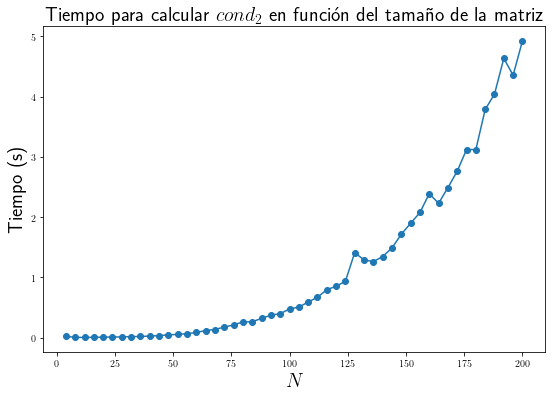

In [10]:
fig = plt.figure(figsize=(3*3, 2*3))
plt.scatter(params['N'],times)
plt.plot(params['N'],times)
plt.xlabel('$N$', size=20)
plt.ylabel('Tiempo (s)', size=20)
plt.title('Tiempo para calcular $cond_2$ en función del tamaño de la matriz', size=20)
plt.show()

# Parte b

## Ecuación en Dominios Perforados

Para $\Omega = [0, 1]^2\backslash B ((0.5, 0.5), 0.3)$, considere:
$$
\left(  P \right)  \left\{
\begin{array}
[c]{ccc}
-\Delta u(x,y)=&0,  & \text{si }(x,y)\text{ en }\Omega \\
u(x,y)=&g(x,y), & \text{si} (x,y)\text{ en }\partial\Omega
\end{array}
\right.
$$

y $g$ dada por:

$$
g\left(  x,y\right)  =\left\{
\begin{array}
[c]{cc}
2  & \text{si }(x,y) \in \partial [0,1]^2 \\
0  & \text{si }(x,y) \in \partial B ((0.5, 0.5), 0.3)
\end{array}
\right.
$$






**P1.** Genere una función que reciba un punto de la malla $(x_j , y_k)$ y entregue como resultado $1$ si es un
punto interior al cual se le puede calcular $\Delta u$ con la aproximación utilizada en la fórmula de $5$ puntos.

In [11]:
def can(x, y, N):
    
    "Función que indica si el punto está en [0,1]^2\B(0.5,0.3)"
    def isin(x, y):
        if 0<=x<=1 and 0<=y<=1:
            return np.linalg.norm((x-0.5, y-0.5), ord=2)>=0.3
        return False
    
    h = 1/(N+1)

    "Obtenemos los vecinos horizontales y verticales"
    neighbours_x = [(x+h*(-1)**i, y) for i in range(2)]
    neighbours_y = [(x, y+h*(-1)**i) for i in range(2)]
    
    return all([isin(*n) for n in neighbours_x]), all([isin(*n) for n in neighbours_y])

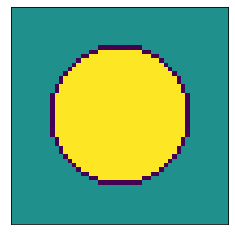

In [12]:
N = 50

im = np.zeros((N, N))
for i in range(1,N+1):
    for j in range(1,N+1):  
        x, y = i/(N+1), j/(N+1)
        cc = can(x, y, N)
        im[i-1, j-1] = 4*all(cc)
        im[i-1, j-1] += 8*int(np.linalg.norm((x-0.5, y-0.5), ord=2)<0.3)
plt.imshow(im,origin='lower')
plt.xticks([])
plt.yticks([]);

**P2.** Asuma que la matriz del sistema es de la forma $A = A_x + A_y$, donde $A_x$ tiene los coeficientes adecuados
para la aproximación de la derivada parcial según $x$ y lo equivalente para $A_y$. Encuentre la forma
que deben tener $A_x$ y $A_y$ y escriba un programa que calcule dichas matrices.

In [13]:
def Ahx(N):
    h = 1/(N+1)

    "Inicializamos Ax como una matriz nula"
    Ax = np.zeros((N**2, N**2))
    
    "Revisamos la fila n de la matriz"
    for n in range(N**2):

        "Obtenemos las coordenadas en la grilla"
        i, j = n%N, n//N

        "Obtenemos las coordenadas en el plano cartesiano"
        x, y = (i+1)*h, (j+1)*h

        "Chequeamos si el punto está fuera de la bola, si no, la fila se queda nula"
        if np.linalg.norm((x-0.5, y-0.5), ord=2)>=0.3:
            canx, _ = can(x, y, N)

            "Chequeamos si se puede aproximar la derivada en x"
            if canx:

                "Se puede, así que rellenamos normalmente"
                Ax[n, n] = 2

                "Si i=0 estamos en el borde izquierdo, luego no hay vecino izquierdo"
                if i>0:
                    Ax[n, n-1] = -1

                "Si i=N-1 estamos en el borde derecho, luego no hay vecino derecho"
                if i<N-1:
                    Ax[n, n+1] = -1

            else:
                "No se puede, así que debemos usar la combinación lineal con alfa y beta"

                """Chequeamos si el punto está en la mitad izquierda, en cuyo caso, 
                el vecino que está en la frontera de la bola está en la mitad izquierda de la bola"
                """
                if x < 0.5:
                    xbola = 0.5 - np.sqrt(0.3**2 - (y-0.5)**2)
                    k = abs(xbola-x) 

                    "Rellenamos con -beta en la diagonal"
                    Ax[n, n] = 2/(h*k) 
                    
                    """No tiene vecino derecho en la grilla, así que solo importa el vecino
                    izquierdo y lo rellenamos con -alfa
                    """
                    if i>0:
                        Ax[n, n-1] = -2/(h*(h+k))

                else:
                    """El punto está en la mitad derecha, así que el vecino que está en la frontera
                    de la bola está en la mitad derecha de la bola
                    """
                    xbola = 0.5 + np.sqrt(0.3**2 - (y-0.5)**2)
                    k = abs(xbola-x) 

                    "Rellenamos con -beta en la diagonal"
                    Ax[n, n] = 2/(h*k)    

                    """No tiene vecino izquierdo en la grilla, así que solo importa el vecino
                    derecho y lo rellenamos con -alfa
                    """
                    if i<N-1:
                        Ax[n, n+1] = -2/(h*(h+k))

    return Ax/(h**2)

def Ahy(N):
    h = 1/(N+1)

    "Inicializamos Ax como una matriz nula"
    Ay = np.zeros((N**2, N**2))

    "Revisamos la fila n de la matriz"
    for n in range(N**2):

        "Obtenemos las coordenadas en la grilla"
        i, j = n%N, n//N

        "Obtenemos las coordenadas en el plano cartesiano"
        x, y = (i+1)*h, (j+1)*h

        "Chequeamos si el punto está fuera de la bola, si no, la fila se queda nula"
        if np.linalg.norm((x-0.5, y-0.5), ord=2)>=0.3:
            _, cany = can(x, y, N)

            "Chequeamos si se puede aproximar la derivada en y"
            if cany:

                "Se puede, así que rellenamos normalmente"
                Ay[n, n] = 2

                "Si j=0 estamos en el borde inferior, luego no hay vecino abajo"
                if j>0:
                    Ay[n, n-N] = -1

                "Si j=N-1 estamos en el borde superior, luego no hay vecino arriba"
                if j<N-1:
                    Ay[n, n+N] = -1

            else:
                "No se puede, así que debemos usar la combinación lineal con alfa y beta"

                """Chequeamos si el punto está en la mitad inferior, en cuyo caso, 
                el vecino que está en la frontera de la bola está en la mitad inferior de la bola"
                """
                if y < 0.5:  
                    ybola = 0.5-np.sqrt(0.3**2 - (x-0.5)**2)
                    k = abs(ybola-y)

                    "Rellenamos con -beta en la diagonal"
                    Ay[n, n] = 2/(h*k) 

                    """No tiene vecino arriba en la grilla, así que solo importa el vecino
                    abajo y lo rellenamos con -alfa
                    """    
                    if j>0:
                        Ay[n, n-N] = -2/(h*(h+k))
                else:
                    """El punto está en la mitad superior, así que el vecino que está en la frontera
                    de la bola está en la mitad superior de la bola
                    """
                    ybola = 0.5+np.sqrt(0.3**2 - (x-0.5)**2)
                    k = abs(ybola-y) 

                    "Rellenamos con -beta en la diagonal"
                    Ay[n, n] = 2/(h*k)    

                    """No tiene vecino abajo en la grilla, así que solo importa el vecino
                    arriba y lo rellenamos con -alfa
                    """
                    if j<N-1:
                        Ay[n, n+N] = -2/(h*(h+k))
    return Ay/(h**2)

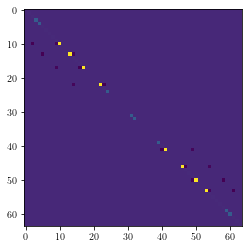

In [14]:
N = 8
plt.imshow(Ahx(N)+Ahy(N))#,origin='lower')

**P3.** Escriba una función que calcule $b_h$ adaptado a este caso.

In [15]:
def bh(N):
    h = 1/(N+1)

    "Inicializamos el vector b como nulo"
    b = np.zeros(N**2)

    "Definimos la función g que es 2 en la frontera del cuadrado unitario y 0 en el resto"
    g = lambda x,y: 2 if (x*y==0 or (1-x)*(1-y)==0) else 0

    "Revisamos cada componente de b"
    for n in range(N**2):

        "Obtenemos el punto en la grilla asociado a esa componente"
        i, j = n%N, n//N

        "Obtenemos el punto en el plano cartesiano asociado"
        x, y = (i+1)*h, (j+1)*h
        
        "Estamos en el borde izquierdo"
        if i==0:
            b[n] += g(0,y)/(h**2)
        
        "Estamos en el borde derecho"
        if i==N-1:
            b[n] += g(1,y)/(h**2)
        
        "Estamos en el borde inferior"
        if j==0:
            b[n] += g(x,0)/(h**2)

        "Estamos en el borde superior"
        if j==N-1:
            b[n] += g(x,1)/(h**2)
    return b

def solve2(N):
    "Obtenemos la matriz A y el vector b"
    A = Ahx(N)+Ahy(N)
    b = bh(N)

    "Debemos eliminar las filas de A que tengan solo ceros"

    """Creamos una lista que contendrá los índices de las filas
    en las que no todos son ceros
    """
    indices = []

    "Revisamos cada fila"
    for n in range(N**2):
        j = 0

        "Mientras vea ceros en la fila sigo revisando"
        while j<N**2 and A[n,j]==0:
            j+=1
        
        "Si j=N^2, entonces la fila está llena de ceros"
        if j != N**2:
            indices.append(n)
    
    "Eliminamos las filas que tienen solo ceros"
    A0 = csc_matrix(A[indices,:][:,indices])
    b0 = b[indices]

    "Resolvemos"
    u0 = spsolve(A0,b0)

    "Agregamos las componentes que faltantes"
    u = np.zeros(N**2)
    for i,j in enumerate(indices):
        u[j] = u0[i]
    return u

**P4.** Resuelva el sistema y grafique la solución aproximada para $N = 10, 20, 30, 40, 50$. Comente sus resultados.

In [16]:
params = {"N": [10, 20, 30, 40, 50, 60]}

"Resolvemos para cada N dado"
u = []
for N in params["N"]:
    uN = solve2(N)
    u.append(uN)
    
"Añadimos el borde para cada N dado"
bu = []
g = lambda x,y: 2 if (np.isclose(x*y, 0) or np.isclose((1-x)*(1-y), 0)) else 0
for k, N in enumerate(params["N"]):
    buN = np.zeros((N+2, N+2))
    h = 1/(N+1)
    for i in range(N+2):
        for j in range(N+2):
            if 0<i<N+1:
                if 0<j<N+1:
                    buN[i, j] += u[k].reshape(N, N)[i-1, j-1]
            if i*j==0 or (N+1-i)*(N+1-j)==0:
                buN[i, j] += g(i*h,j*h)
    bu.append(buN)

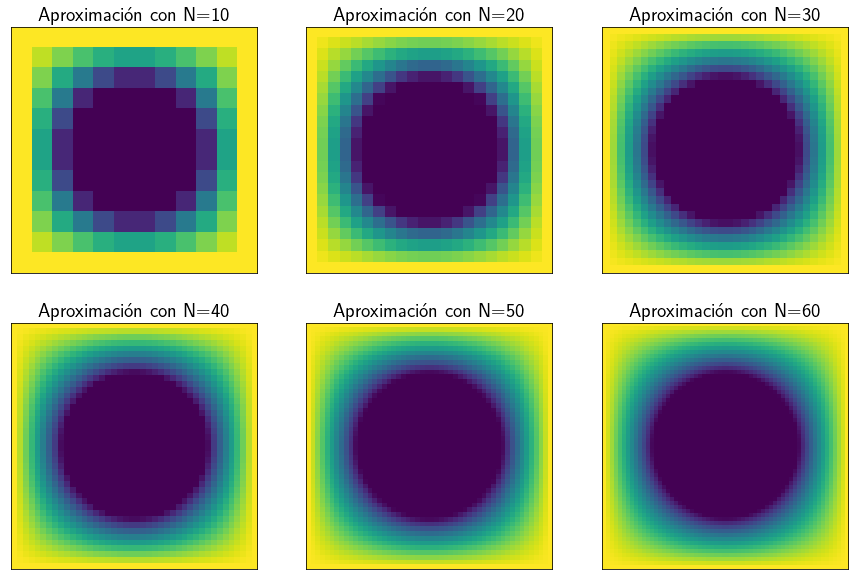

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(3*5, 2*5))
for k in range(len(params["N"])):
    N = params["N"][k]
    i, j = k//3, k%3
    axk = ax[i, j]
    axk.imshow(bu[k], origin="lower")
    axk.set_title(f"Aproximación con N={N}", size=20)
    axk.set_xticks([])
    axk.set_yticks([])

**Comentarios:** 

**P5.** ¿Qué sucede con el condicionamiento de la matriz utilizando la fórmula de la Parte a?¿Cómo adaptaría su código para el caso $f\neq 0$?

In [18]:
def cond_2_sparse_non_symmetric(A):
    N =   A.shape[0]
    indices = []
    for n in range(N):
        j = 0
        while j<N and A[n,j]==0:
            j+=1
        if j != N:
            indices.append(n)
    A0 = csc_matrix(A[indices,:][:,indices])

    l_max = eigs(A0,k=1,which='LM')[0][0]
    l_min = eigs(A0,k=1,which='SM')[0][0]
    cond = abs(l_max)/abs(l_min)
    return cond

In [19]:
params = {"N": [k for k in range(3, 100)]}

Ns = []
cond = []
times = []

for k, N in enumerate(params['N']):
    
    if N%10==9:
        pass
    else:
        
        try:
            start_time = time.time()
            
            cond.append(cond_2_sparse_non_symmetric(Ahx(N)+Ahy(N)))
            Ns.append(N)
            
            dt = time.time()-start_time
            times.append(dt)
            print(f"""
            row: {k+1}, total_rows: {len(params['N'])}
            progress: {np.round(100*(k+1)/len(params['N']), 3)}%
            dt: {dt}
            expected end-time: {datetime.timedelta(seconds = np.mean(times)*(len(params['N'])-k-1))}s
            """)
        except Exception as e:
            pass
    


            row: 1, total_rows: 97
            progress: 1.031%
            dt: 0.005368709564208984
            expected end-time: 0:00:00.515396s
            

            row: 2, total_rows: 97
            progress: 2.062%
            dt: 0.002002239227294922
            expected end-time: 0:00:00.350120s
            

            row: 3, total_rows: 97
            progress: 3.093%
            dt: 0.0020020008087158203
            expected end-time: 0:00:00.293686s
            

            row: 4, total_rows: 97
            progress: 4.124%
            dt: 0.0040035247802734375
            expected end-time: 0:00:00.311003s
            

            row: 5, total_rows: 97
            progress: 5.155%
            dt: 0.0050046443939208984
            expected end-time: 0:00:00.338213s
            

            row: 6, total_rows: 97
            progress: 6.186%
            dt: 0.006005764007568359
            expected end-time: 0:00:00.369868s
            

            row: 8, tota


            row: 61, total_rows: 97
            progress: 62.887%
            dt: 5.982442855834961
            expected end-time: 0:00:53.807289s
            

            row: 63, total_rows: 97
            progress: 64.948%
            dt: 7.92621922492981
            expected end-time: 0:00:54.943910s
            

            row: 64, total_rows: 97
            progress: 65.979%
            dt: 9.699825525283813
            expected end-time: 0:00:58.268030s
            

            row: 65, total_rows: 97
            progress: 67.01%
            dt: 13.470267295837402
            expected end-time: 0:01:03.312263s
            

            row: 66, total_rows: 97
            progress: 68.041%
            dt: 14.267991304397583
            expected end-time: 0:01:08.136862s
            

            row: 68, total_rows: 97
            progress: 70.103%
            dt: 10.45250940322876
            expected end-time: 0:01:07.940616s
            

            row: 69, total_rows: 

C:\Users\felip\AppData\Local\Temp/ipykernel_12584/599714755.py:57: RuntimeWarning: invalid value encountered in sqrt
  xbola = 0.5 + np.sqrt(0.3**2 - (y-0.5)**2)
C:\Users\felip\AppData\Local\Temp/ipykernel_12584/599714755.py:126: RuntimeWarning: invalid value encountered in sqrt
  ybola = 0.5+np.sqrt(0.3**2 - (x-0.5)**2)



            row: 91, total_rows: 97
            progress: 93.814%
            dt: 92.76300597190857
            expected end-time: 0:01:08.217406s
            

            row: 93, total_rows: 97
            progress: 95.876%
            dt: 111.35924625396729
            expected end-time: 0:00:50.883118s
            

            row: 94, total_rows: 97
            progress: 96.907%
            dt: 27.639161586761475
            expected end-time: 0:00:38.759074s
            

            row: 95, total_rows: 97
            progress: 97.938%
            dt: 114.07614254951477
            expected end-time: 0:00:28.501395s
            


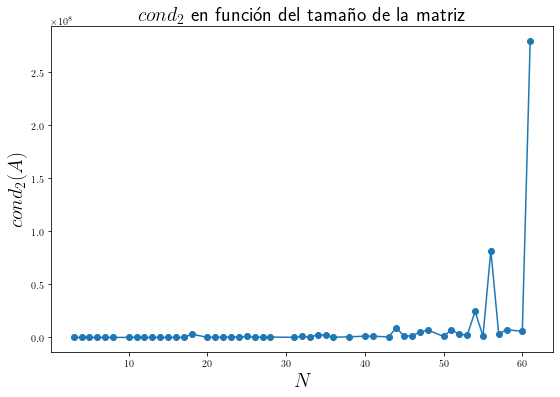

In [20]:
fig = plt.figure(figsize=(3*3, 2*3))
plt.scatter(Ns[:50],cond[:50])
plt.plot(Ns[:50],cond[:50])
plt.xlabel('$N$', size=20)
plt.ylabel('$cond_2(A)$', size=20)
plt.title('$cond_2$ en función del tamaño de la matriz', size=20)
plt.show()

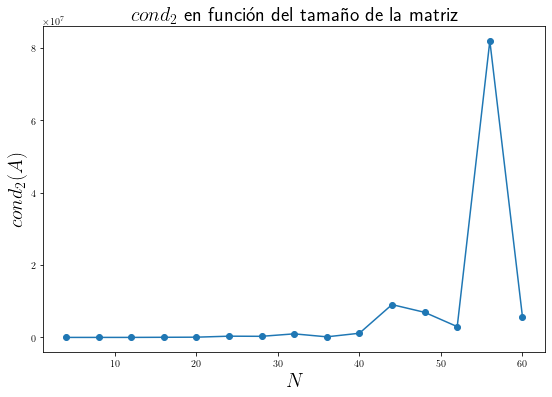

In [21]:
params = {"N": [4*(k+1) for k in range(15)]}

cond = []
for N in params['N']:
    cond.append(cond_2_sparse_non_symmetric(Ahx(N)+Ahy(N)))

fig = plt.figure(figsize=(3*3, 2*3))
plt.scatter(params['N'],cond)
plt.plot(params['N'],cond)
plt.xlabel('$N$', size=20)
plt.ylabel('$cond_2(A)$', size=20)
plt.title('$cond_2$ en función del tamaño de la matriz', size=20)
plt.show()